# 분류 Classification

## MNIST

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

matplotlib.rc('font')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

x = np.vstack((train_x, test_x))
x = x.reshape([-1, 28*28])
y = np.append(train_y, test_y)

print('x.shape:', x.shape)
print('y.shape:', y.shape)

x.shape: (70000, 784)
y.shape: (70000,)


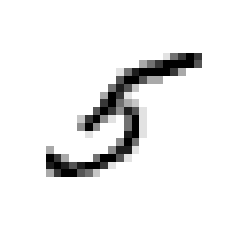

In [4]:
some_digit = x[35]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
# MNIST데이터셋을 train set, test set 나누기
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
x_trian, y_train = x_train[shuffle_index], y_train[shuffle_index]

print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_trian.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)
y_trian.shape: (60000,)
y_test.shape: (10000,)


## 이진 분류기 훈련

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

np.where(y_train == 5)

(array([    8,    11,    25, ..., 59928, 59942, 59965], dtype=int64),)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([False])

## 성능 측정

In [9]:
# 교차 검증을 사용한 정확도 측정
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.86415, 0.9051 , 0.89835])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train_5[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.86415
0.9051
0.89835


In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90745, 0.9125 ])

In [12]:
# 오차행렬 (Confusion Matrix)
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)
y_train_pred

array([False, False,  True, ..., False, False,  True])

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53220,  1359],
       [ 5289,   132]], dtype=int64)

In [37]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [14]:
# 정밀도 (Precision) : 맞음긍정 / (맞음긍정 + 틀림긍정) = 긍정인거/긍정이라고한거
precision = 132 / (132+1359)
print('precision:', precision)

from sklearn.metrics import precision_score
print('precision_score:', precision_score(y_train_5, y_train_pred))

precision: 0.08853118712273642
precision_score: 0.08853118712273642


In [15]:
# 재현율 (Recall) : 맞음긍정 / (맞음긍정 + 틀림부정) = 긍정인거/실제긍정인거
recall = 132 / (132+5289)
print('recall:', recall)

from sklearn.metrics import recall_score
print('recall_score:', recall_score(y_train_5, y_train_pred))

recall: 0.024349750968456003
recall_score: 0.024349750968456003


In [16]:
# F1 score : precision과 recall의 조화평균
f1_score_ = 132 / (132 + (1359 + 5289)/2)
print('f1_score_:', f1_score_)

from sklearn.metrics import f1_score
print('f1_score:', f1_score(y_train_5, y_train_pred))

f1_score_: 0.03819444444444445
f1_score: 0.03819444444444444


In [17]:
# 정밀도 / 재현율 Trade-off
y_scores = sgd_clf.decision_function([some_digit])
print('y_scores:', y_scores)

threshold = 0
y_some_digit_pred = (y_scores < threshold)
print('y_some_digit_pred:', y_some_digit_pred)

threshold = -200000
y_some_digit_pred = (y_scores < threshold)
print('y_some_digit_pred:', y_some_digit_pred)

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                             method='decision_function')
print('y_scores.shape:', y_scores.shape)
print('y_scores:', y_scores)

y_scores: [-126622.57609546]
y_some_digit_pred: [ True]
y_some_digit_pred: [False]
y_scores.shape: (60000,)
y_scores: [-431779.24568507 -151267.15358511   54670.73665314 ... -268293.62435562
 -440790.35319507   68531.18571806]


In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

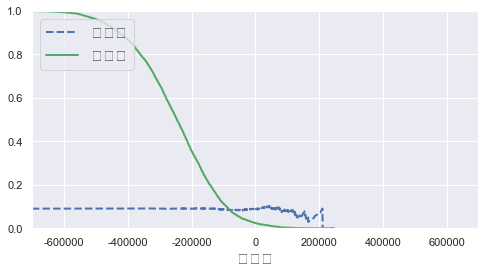

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율', linewidth=2)
    plt.xlabel('임계값', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000,700000])
plt.show()

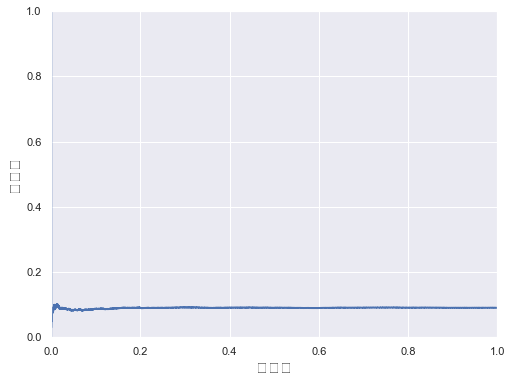

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [21]:
# ROC 곡선 (민감도)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

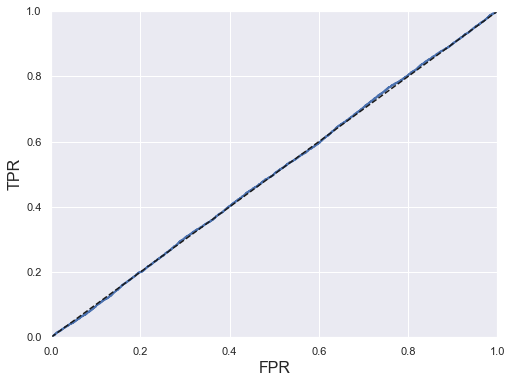

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

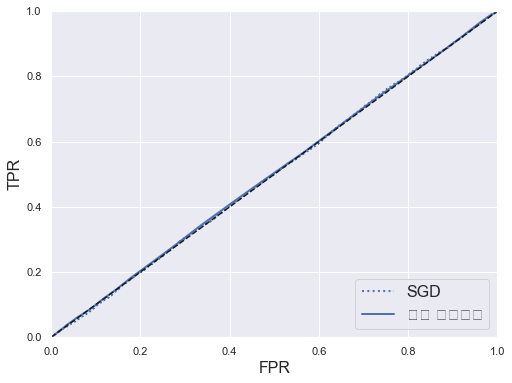

In [23]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 점수는 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.5011505875064355

## 다중분류

In [25]:
# OvA : One vs All
# OvO : One vs One

In [26]:
sgd_clf.fit(x_train, y_train)

SGDClassifier(max_iter=5, random_state=42)

In [27]:
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [28]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -17078.23622126,  -17660.65908942,  -40483.86832773,
        -160012.02850199,   22876.42924788,  -45630.1023407 ,
         -88482.28411003,  -15225.27682809, -164193.62446806,
        -108003.13265543]])

In [29]:
np.argmax(some_digit_scores)

4

In [30]:
# OvO or OvA
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(x_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(max_iter=5, random_state=42))

In [31]:
ovo_clf.predict([some_digit])

array([7], dtype=uint8)

In [32]:
len(ovo_clf.estimators_)

45

In [33]:
# Random Forest
forest_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
forest_clf.predict([some_digit])

array([1], dtype=uint8)

In [35]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.097  , 0.09855, 0.09935])

In [38]:
# StandardScaler 데이터 스케일 조정
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.0981, 0.1015, 0.1018])

## 에러분석

In [40]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[592, 577, 753, 698, 603, 514, 397, 623, 507, 659],
       [747, 655, 810, 791, 651, 564, 407, 748, 619, 750],
       [622, 622, 757, 656, 595, 531, 402, 631, 501, 641],
       [620, 596, 774, 684, 638, 570, 378, 701, 540, 630],
       [626, 598, 720, 650, 590, 500, 371, 677, 482, 628],
       [532, 482, 672, 628, 606, 483, 365, 617, 466, 570],
       [586, 600, 731, 678, 601, 509, 386, 651, 520, 656],
       [637, 595, 806, 738, 675, 506, 374, 722, 525, 687],
       [637, 566, 728, 674, 601, 527, 379, 619, 503, 617],
       [585, 610, 671, 716, 605, 548, 388, 641, 529, 656]], dtype=int64)

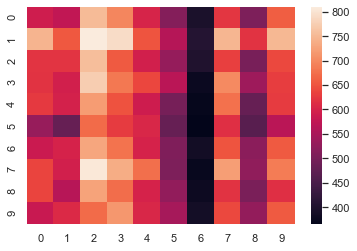

In [41]:
sn.heatmap(conf_mx)

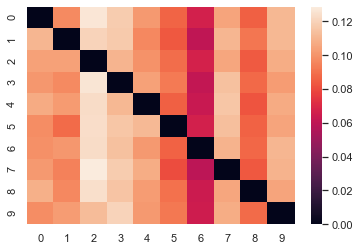

In [43]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
sn.heatmap(norm_conf_mx)

In [44]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

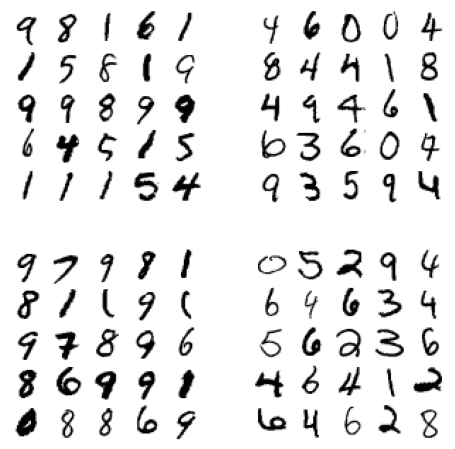

In [46]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중 레이블 분류

In [49]:
# KNN 알고리즘 이용
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [50]:
knn_clf.predict([some_digit])

array([[False, False]])

## 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [ ]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')

In [ ]:
some_index = 5501
plt.subplot(121); plot_digit(x_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn.clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)